# Multi-Head Attention on Decoder

This notebook augments the Bahdanau decoder with **multi-head attention** while keeping the GRU encoder/decoder structure unchanged.
It demonstrates how to project queries/keys/values per head, concatenate the attended context, and continue training on the
MT French/English dataset using the exact training/evaluation loop from the Bahdanau notebook.


In [1]:
import importlib
import hw7
importlib.reload(hw7)
from hw7 import *
from tsv_seq2seq_data import TSVSeq2SeqData 
import os

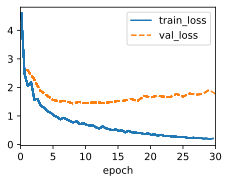

In [2]:

# data_path = os.path.expanduser('~/Dropbox/CS6140/data/sentence_pairs_large.tsv')
# data = TSVSeq2SeqData(
#     path=data_path,
#     batch_size=512,
#     num_steps=25,
#     min_freq=2,
#     val_frac=0.05,
#     test_frac=0.0,
#     sample_percent=1,
# )

data = d2l.MTFraEng(batch_size=128)

# embed_size = 256
# num_hiddens = 320 
# num_blks = 3 
# num_layers =3
# dropout = 0.4 
# num_heads = 4

embed_size = 512
num_hiddens = 512 
num_blks = 3 
num_layers =4
dropout = 0.1 
num_heads = 8

encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = MultiHeadSeq2SeqDecoder(len(data.tgt_vocab), embed_size,
                                  num_hiddens, num_layers, num_heads=num_heads, dropout=dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.002)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


In [ ]:
# engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# preds, _ = model.predict_step(
#     data.build(engs, fras), d2l.try_gpu(), data.num_steps)
# for en, fr, p in zip(engs, fras, preds):
#     translation = []
#     for token in data.tgt_vocab.to_tokens(p):
#         if token == '<eos>':
#             break
#         translation.append(token)
#     print(f'{en} => {translation}, bleu,'
#           f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')
    
# examples=engs
# references=fras

go . => ['<unk>', '!'], bleu,0.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'a', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'certain', '.'], bleu,0.512


In [3]:
examples = ['vamos .', 'me perdi .', 'esta tranquilo .', 'estoy en casa .', 'donde esta el tren ?',    'necesito ayuda urgente .',
    'ayer llovio mucho en la ciudad .', 'los ninos estan jugando en el parque .', 'ella quiere aprender a hablar ingles muy bien .',
    'cuando llegara el proximo tren a madrid ?']

references = ['go .', 'i got lost .', 'he is calm .', 'i am at home .', 'where is the train ?',
    'i need urgent help .', 'it rained a lot in the city yesterday .',
    'the children are playing in the park .', 'she wants to learn to speak english very well .', 'when will the next train to madrid arrive ?']

preds, _ = model.predict_step(
    data.build(examples, references), d2l.try_gpu(), data.num_steps)
for src, tgt, pred in zip(examples, references, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(pred):
        if token == '<eos>':
            break
        translation.append(token)
    
    hypo = ' '.join(translation)
    print(f"{src} => {hypo} | reference: {tgt} BLEU: {d2l.bleu(hypo, tgt, k=2):.3f}")
    

vamos . => we're go! | reference: go . BLEU: 0.000
me perdi . => i kicked | reference: i got lost . BLEU: 0.000
esta tranquilo . => this will will | reference: he is calm . BLEU: 0.000
estoy en casa . => i'm am at | reference: i am at home . BLEU: 0.353
donde esta el tren ? => where this rent runs | reference: where is the train ? BLEU: 0.000
necesito ayuda urgente . => i need to help to | reference: i need urgent help . BLEU: 0.548
ayer llovio mucho en la ciudad . => we swam a lot tourists the in the | reference: it rained a lot in the city yesterday . BLEU: 0.456
los ninos estan jugando en el parque . => the <unk> <unk> in in the the | reference: the children are playing in the park . BLEU: 0.363
ella quiere aprender a hablar ingles muy bien . => she wants to speak to very well well. well. well. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> | reference: she wants to learn to speak english very well . BLEU: 0.338
cuando llegara el proximo tr

Optional : Beam search instead of the greedy (armax) decoder : try to assign probabilites for entire sequence, before picking the output. Uses dynamic programing. 

In [8]:



jj=-1

# Build a single batch for the last example/reference pair

src, tgt_inputs, src_lens, tgt_lens = data.build([examples[jj]], [references[jj]])
device = d2l.try_gpu()
src, tgt_inputs, src_lens = src.to(device), tgt_inputs.to(device), src_lens.to(device)

# Run encoder + decoder with teacher forcing to collect attention at every timestep
enc_outputs = model.encoder(src, src_lens)
dec_state = model.decoder.init_state(enc_outputs, src_lens)
_ = model.decoder(tgt_inputs, dec_state)   # forward pass stores weights on decoder.attention_weights

dec_attention_weights = model.decoder.attention_weights       # list length = number of decoder steps
weights = torch.stack(dec_attention_weights)                  # (num_steps, batch*num_heads, 1, num_keys)
num_steps, flat_batch, _, num_keys = weights.shape
num_heads = model.decoder.attention.num_heads
batch_size = flat_batch // num_heads

weights = weights.view(num_steps, num_heads, batch_size, num_keys)
weights = weights.permute(2, 1, 0, 3)                          # (batch, num_heads, num_steps, num_keys)

# Average over heads, then crop to actual source/target lengths
avg_weights = weights.mean(dim=1, keepdim=True)                # (batch, 1, num_steps, num_keys)
src_len = src_lens.item()
tgt_len = tgt_lens.item()                                      # decoder steps actually used
heatmap = avg_weights[:, :, :tgt_len, :src_len].cpu()

d2l.show_heatmaps(
    heatmap, xlabel='Key positions', ylabel='Query positions'
)





RuntimeError: a Tensor with 9 elements cannot be converted to Scalar

In [6]:
for src, tgt in zip(examples, references):
    src_sentence = src.lower().split()
    src_tokens = [data.src_vocab[token] for token in src_sentence]
    pred_ids = beam_search_translate(model, src_tokens, data, beam_size=5,  max_steps=40)
    translation = data.tgt_vocab.to_tokens(pred_ids)
    hypo = ' '.join(translation)
    print(f"{src} => {hypo}    |  reference: {tgt}  | BLEU: {d2l.bleu(hypo, tgt, k=2):.3f}")

vamos . => we're going to <unk> and the <unk> are all <unk> by the milky side of the dead. a lot. <eos>    |  reference: go .  | BLEU: 0.000
me perdi . => you have to pay me, and <unk> me. the one is getting a ride? the youngster is getting married. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>    |  reference: i got lost .  | BLEU: 0.000
esta tranquilo . => this sentence is in this way. and it is a bit of telling a lie. the same is a bit of the same. <eos>    |  reference: he is calm .  | BLEU: 0.000
estoy en casa . => i'm in the right now. i'm in the home perfectly. he has a lot of project. the right is getting better. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>    |  reference: i am at home .  | BLEU: 0.000
donde esta el tren ? => the one where to put this room. <eos>    |  reference: where is the train ?  | BLEU: 0.000
necesito ayuda 